# Recurrent Neural Network Long-Short Term Memory (LSTM)

### Com objetivo de explorar o potencial das redes neurais recorrentes LSTM, um caso de análise de dados de séries temporais coletados em um processo real da indústria de papel e celulose é proposto. A base de dados a ser analisada é composta por dados de operação de um processo Kraft para produção de celulose.

### Bibliotecas a serem utilizadas

In [1]:
import os 
import numpy as np
from math import ceil
from matplotlib import pyplot as plt
from keras.models import  Sequential
from keras import layers
from keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### Importação dos dados

In [2]:
# leitura dos dados
f = open('caustificacao_dados.csv')
data = f.read()
f.close()
# convertendo em matriz
lines = data.split('\n')
num_rows = len(lines)
num_cols = len(lines[0].split(','))-1
float_data = np.zeros((num_rows, num_cols))
for i, line in enumerate(lines):
    values = [float(value) for value in line.split(',')[1:]]
    float_data[i, :] = values

### Normalização dos dados de treinamento

In [3]:
mean_alc_ef = float_data[:4380, -1].mean(axis=0)
std_alc_ef = float_data[:4380, -1].std(axis=0)
mean = float_data[:4380].mean(axis=0)  
float_data -= mean
std = float_data[:4380].std(axis=0)
float_data /= std

### Função para geração de bateladas de dados a serem inseridas na rede neural

In [4]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32, step=1):
    # data: the original array of floating-point data, which was normalized
    # lookback: how many timesteps back the input data should go (set it to 12 to go back 24 hours) 
    # delay: how many timesteps in the future the target should be (set it to 0 to get targets at the
    #  current timestep)
    # min_index and max_index: indices in the data array that delimit which time-steps to draw from, useful 
    #  for keeping a segment of for validation and another for testing
    # shuffle: whether to shuffle the samples or draw them in chronological order
    # batch_size: the number of samples per batch
    # step: the period, in timesteps, at which you sample data (set it to 1 in order to draw one data point 
    #  every 2 hours)
    # a timestep is 2 hours

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index)) # create evenly spaced values
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1])) # 3D array (batch-size, lookback, num_cols)
        targets = np.zeros((len(rows),)) # 1D array for target values 
        for j, row in enumerate(rows):
            indices = range(row - lookback, row, step) # indice of the database values that will be use as lookback values  
            samples[j] = data[indices]
            targets[j] = data[row + delay][-1] 
        yield samples, targets # generate one batch

### Geração dos dados de treino, validação e teste

In [5]:
lookback = 12 # 24 hours before
step = 1 # analysis at each 2 hours
delay = 0 # forecast the value at current time step
batch_size = 32

# dados de treino
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=4380, 
                      shuffle=True, step=step, batch_size=batch_size)
# dados de validação
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=4380, max_index=7284, 
                    step=step, batch_size=batch_size)
# dados de teste
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=7284, max_index=None, 
                    step=step, batch_size=batch_size)
# dados de teste
target_gen = generator(float_data, lookback=lookback, delay=delay, min_index=7284, max_index=None, 
                      step=step, batch_size=batch_size)
# dados de teste
eval_test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=7284, max_index=None, 
                        step=step, batch_size=batch_size)

# número de iterações por epoch durante treino
train_steps = ceil((4380 - 0 - lookback) / batch_size)
# número de iterações por epoch durante validação
val_steps = ceil((7284 - 4380 - lookback) / batch_size) # how many steps to draw from val_gen in order to see the entire validation set                                      
# número de iterações por epoch durante teste
test_steps = ceil((len(float_data) - 7284 - lookback) / batch_size) # how many steps to draw from test_gen in order to see the entire test set

### Modelo da rede neural a ser implementada
Opta-se pela implementação de uma rede LSTM com uma camada com 32 unidades LSTM e uma camada de saída

In [6]:
model = Sequential()
model.add(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3, input_shape=(None, float_data.shape[-1]))) # utiliza-se dropout para evitar overfitting
model.add(layers.Dense(1))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Treinamento da rede neural 

In [7]:
# otimizador utilizado para o backpropagation through time é o RMSprop
# função erro é MSE
model.compile(optimizer=RMSprop(), loss='mse') 
# inicia treinamento 
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=40, validation_data=val_gen, 
                              validation_steps=val_steps)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/40
137/137 [==============================] - 5s 38ms/step - loss: 0.8278 - val_loss: 0.4974
Epoch 2/40
137/137 [==============================] - 3s 20ms/step - loss: 0.7681 - val_loss: 0.4246
Epoch 3/40
137/137 [==============================] - 3s 22ms/step - loss: 0.7637 - val_loss: 0.3606
Epoch 4/40
137/137 [==============================] - 3s 23ms/step - loss: 0.7577 - val_loss: 0.3507
Epoch 5/40
137/137 [==============================] - 3s 22ms/step - loss: 0.7111 - val_loss: 0.3229
Epoch 6/40
137/137 [==============================] - 3s 21ms/step - loss: 0.6838 - val_loss: 0.3205
Epoch 7/40
137/137 [==============================] - 3s 21ms/step - loss: 0.5870 - val_loss: 0.3230
Epoch 8/40
137/137 [==============================] - 3s 20ms/step - loss: 0.6219 - val_loss: 0.2941
Epoch 9/40
137/137 [==============================] - 3s 21ms/step - loss: 0.4816 - val_loss: 0.

### Performance do treinamento

The mean training loss is 0.5752898403708517
The mean validation loss is 0.26642051468155403


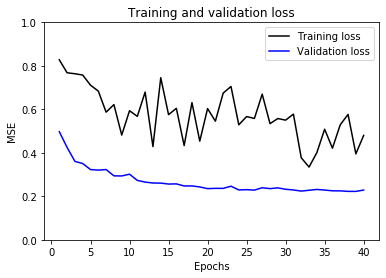

In [8]:
# plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

mean_loss = np.mean(loss)
print(f'The mean training loss is {mean_loss}')

mean_val_loss = np.mean(val_loss)
print(f'The mean validation loss is {mean_val_loss}')

# loss
plt.figure()
plt.plot(epochs, loss, 'k', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.ylim((0, 1))
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Teste da rede neural

The test loss is 0.21741698868572712
Normalized MSE 0.2174169917934281
Unnormalized MSE 4.827420818817049


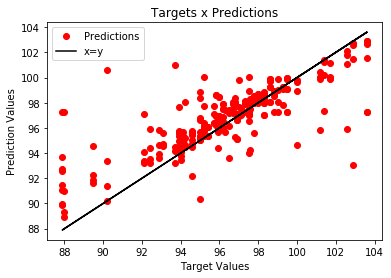

In [9]:
evaluation = model.evaluate_generator(eval_test_gen, steps=test_steps)
print(f'The test loss is {evaluation}')

# plot resultado do teste
# targets x predictions

predictions = model.predict_generator(test_gen, steps=test_steps)

samples, targets = next(target_gen)
for i in range(1,test_steps):
    sample, target = next(target_gen)
    samples = np.concatenate((samples, sample), axis=0)
    targets = np.concatenate((targets, target))

print(f'Normalized MSE {mean_squared_error(predictions, targets)}')

r_targets = (targets*std_alc_ef) + mean_alc_ef
r_predictions = (predictions*std_alc_ef) + mean_alc_ef

print(f'Unnormalized MSE {mean_squared_error(r_predictions, r_targets)}')

plt.figure()
plt.plot(r_targets, r_predictions, 'ro', label='Predictions')
plt.plot(r_targets, r_targets, 'k', label='x=y')
plt.xlabel('Target Values')
plt.ylabel('Prediction Values')
#plt.xlim((97, 100))
#plt.ylim((97, 100))
plt.title('Targets x Predictions')
plt.legend()
plt.show()

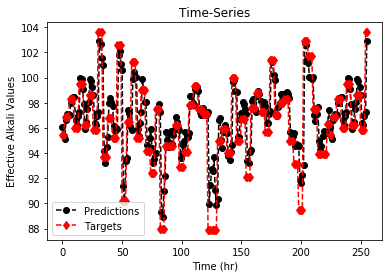

In [10]:
# targets x time vs predictions x time
time = range(0, len(targets))

plt.figure()
plt.plot(time, r_predictions, 'ko--', label='Predictions')
plt.plot(time, r_targets, 'rd--', label='Targets')
plt.xlabel('Time (hr)')
plt.ylabel('Effective Alkali Values')
plt.title('Time-Series')
plt.legend()
plt.show()